<a href="https://colab.research.google.com/github/AnalystGagan/Project-dog-vision/blob/master/Project_dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End-to-End Multi-Class Dog Breed Classification

This notebook builds an End-to-end Multi-Class Image Classifier using Tensorflow Hub.


## 1.Problem
Identifying the breed of a dog given an image of a dog

When I am sitting at the Starbucks and I take a photo of a dog, want to know what breed of a dog it is. 
## 2.Data 
The data we are using is from Kaggel's dog breed identification compitition 

https://www.kaggle.com/c/dog-breed-identification/data
## 3.Evaluation
The Evaluation is a file with prediction probabilities for each dog breed of each test Image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation
## 4.Features
Some information about the data:

* we are dealing with images (unstructured data ) so it is probably best se use deep learning/ transfer learning. 
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in training dataset (These images has labels)
* There are around 10,000+ images in test dataset (These images do not have labels, becasue we'll want to predict them).





In [1]:
# Unzip the uploaded data into google Drive

#!unzip "drive/My Drive/dog-vision-data/dog-breed-identification.zip" -d "drive/My Drive/dog-vision-data/"

### Getting our workspace ready 

* Import TensorFlow 2.x ✔️
* Import TensorFlow Hub ✔️
* Make sure we are using a GPU ✔️


In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version :", tf.__version__)
print("TF Hub version:",hub.__version__)

# Check for GPU availablity 
print("GPU","available (Yessssssss!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version : 2.2.0
TF Hub version: 0.8.0
GPU available (Yessssssss!!!!)


## Getting our data ready (Turning into Tensors)

With all Machine Leanring models, our data has to be in numerical format. So that's what we will be doing first. Turning our images into Tensors(numerical representations)

Let's start by accessing our data and checking out checking out the labels.

In [2]:
# Checkout the labels of our data 
import pandas as pd 
# Path --> /content/drive/My Drive/dog-vision-data/labels.csv
labels_csv = pd.read_csv("drive/My Drive/dog-vision-data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     9d13cfdd4fc7d0f3c3c5fa488facb853  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# How many images are there of each breed
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

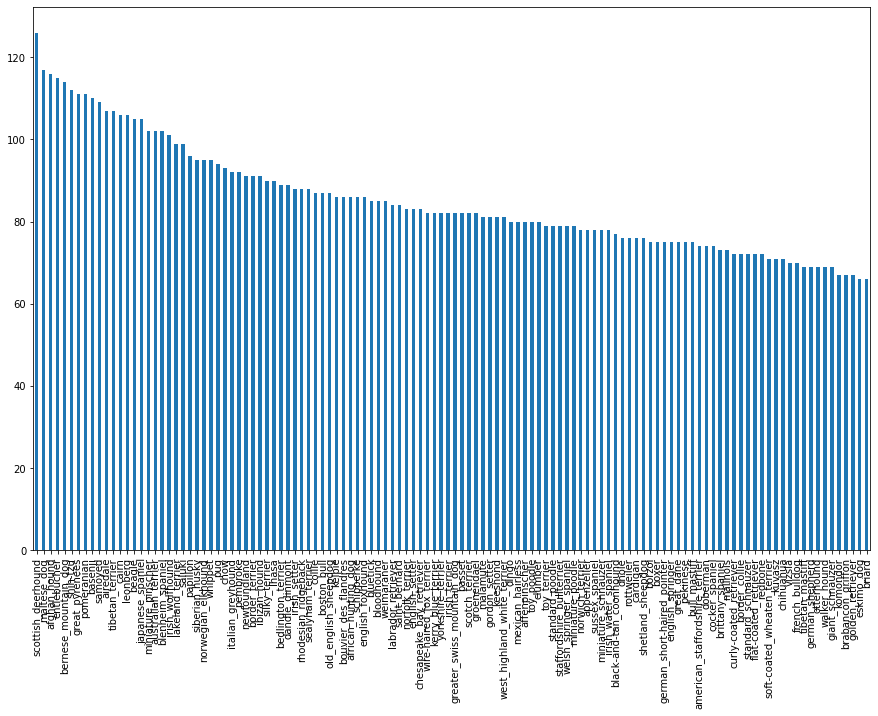

In [5]:
labels_csv["breed"].value_counts().plot.bar(figsize = (15,10));

In [6]:
labels_csv["breed"].value_counts().median()

82.0

*** Good start, our dataset is balance accross each class of breed. 
Google recommends minimum number of images per class should be 10*** 
https://cloud.google.com/vision/automl/object-detection/docs/prepare

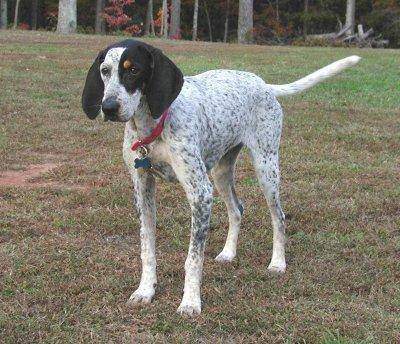

In [7]:
# Let's view an image 
from IPython.display import Image
Image("drive/My Drive/dog-vision-data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels 

Let's get a list of all of our image file pathnames. 

In [9]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# Create a path name from image ID's 
filename = ["drive/My Drive/dog-vision-data/train/"+fname + ".jpg" for fname in labels_csv["id"]]

# Check for the first 10
filename[:10]

['drive/My Drive/dog-vision-data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog-vision-data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog-vision-data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog-vision-data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog-vision-data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/dog-vision-data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/dog-vision-data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/dog-vision-data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/dog-vision-data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/dog-vision-data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [13]:
# Check wheather number of filename matches with number of actual image files
import os 
if len(os.listdir("drive/My Drive/dog-vision-data/train/")) == len(filename):
  print("filename matches  actual numeber of files, Proceed")
else:
  print("filename donot match actual amount of files, check the target directory")


filename matches  actual numeber of files, Proceed
